In [25]:
import cv2
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

np.set_printoptions(precision=6, suppress=True)

In [26]:
# Ruta del video a procesar
video_path = "/content/Video de WhatsApp 2025-09-29 a las 21.18.00_a7f9a9f1.mp4"

# Función para extraer fotogramas (frames) de un video usando OpenCV
def extract_frames(video_path):
    frames = []
    # Inicializar objeto de captura de video
    cap = cv2.VideoCapture(video_path)

    # Verificar si el archivo de video se pudo abrir
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el archivo de video {video_path}")
        return frames

    # Leer los fotogramas en un bucle hasta el final del video
    while True:
        ret, frame = cap.read() # ret: True si el fotograma se leyó correctamente, frame: el fotograma
        if not ret: # Si ret es False, significa que llegamos al final del video
            break
        # Guardar cada fotograma en una lista
        frames.append(frame)

    # Liberar el objeto de captura
    cap.release()
    return frames

# Extraer los fotogramas del video
frames = extract_frames(video_path)

# Validar que se hayan extraído fotogramas
if not frames:
    raise RuntimeError(f"No se extrajeron fotogramas de {video_path}. Verifique la ruta o el archivo.")

print(f"Se extrajeron {len(frames)} fotogramas exitosamente.")

Se extrajeron 602 fotogramas exitosamente.


In [27]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Cargar la plantilla (el objeto de referencia)
plantilla = cv2.imread('/content/prueba.png', cv2.IMREAD_COLOR)

# Verificar que la plantilla se cargó correctamente
if plantilla is None:
    print("Error al cargar la imagen de la plantilla. Verifica la ruta.")
    exit()

# Convertir la plantilla a escala de grises
plantilla_gris = cv2.cvtColor(plantilla, cv2.COLOR_BGR2GRAY)

# Obtener las dimensiones de la plantilla
alto_plantilla, ancho_plantilla = plantilla_gris.shape

# Lista para almacenar las ubicaciones detectadas en cada frame
detected_locations = []

# Lista para almacenar los centroides detectados y el número de frame
centroids = []

# Definir un umbral para considerar coincidencias (ajusta según tus necesidades)
umbral = 0.8

# Iterar sobre cada frame extraído previamente
for i, frame in enumerate(frames):
    # Convertir el frame actual a escala de grises
    frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Realizar la coincidencia de plantillas
    resultado = cv2.matchTemplate(frame_gris, plantilla_gris, cv2.TM_CCOEFF_NORMED)

    # Encontrar ubicaciones que superen el umbral
    ubicaciones = np.where(resultado >= umbral)

    # Si se encontraron ubicaciones
    if len(ubicaciones[0]) > 0:
        # Tomar la primera ubicación encontrada
        punto = (ubicaciones[1][0], ubicaciones[0][0])
        detected_locations.append({'frame': i, 'location': punto})

        # Calcular el centroide del área detectada (aproximación simple al centro del recuadro)
        cx = punto[0] + ancho_plantilla // 2
        cy = punto[1] + alto_plantilla // 2
        centroids.append({'frame': i, 'centroid': (cx, cy)})

        # Opcional: Dibujar rectángulo y centroide en el frame para visualización (solo si deseas mostrar cada frame)
        #cv2.rectangle(frame, punto, (punto[0] + ancho_plantilla, punto[1] + alto_plantilla), (0, 255, 0), 2)
        #cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1) # Dibujar un círculo en el centroide
        #cv2_imshow(frame) # Mostrar el frame con la detección y centroide
    else:
        # Si no se detectó el objeto en este frame
        detected_locations.append({'frame': i, 'location': None})
        centroids.append({'frame': i, 'centroid': None})


print(f"Se procesaron {len(frames)} fotogramas y se registraron las ubicaciones y centroides detectados.")

# Ahora 'detected_locations' contiene una lista de diccionarios con el número de frame y la ubicación detectada (o None)
# Y 'centroids' contiene una lista de diccionarios con el número de frame y el centroide detectado (o None)
# Puedes procesar estas listas para analizar el movimiento del objeto a lo largo del video.

Se procesaron 602 fotogramas y se registraron las ubicaciones y centroides detectados.


In [28]:
import pandas as pd

# Asumiendo una velocidad de fotogramas (FPS) constante para el video.
# Si conoces los FPS reales del video, reemplaza 30.0 con ese valor.
fps = 30.0
time_per_frame = 1.0 / fps

# Crear listas para almacenar los datos del DataFrame
times = []
y_coordinates = []

# Iterar sobre la lista de centroides y el número de frame
for item in centroids:
    frame_number = item['frame']
    centroid = item['centroid']

    # Calcular el tiempo en segundos para este frame
    time_in_seconds = frame_number * time_per_frame

    # Si se detectó un centroide, agregar el tiempo y la coordenada y a las listas
    if centroid is not None:
        times.append(time_in_seconds)
        y_coordinates.append(centroid[1]) # La coordenada y es el segundo elemento de la tupla del centroide

# Crear el DataFrame
centroid_df = pd.DataFrame({
    'Time': times,
    'Y_Coordinate': y_coordinates
})

# Mostrar las primeras filas del DataFrame
print("DataFrame con tiempo y coordenadas Y de los centroides:")
display(centroid_df.head())

DataFrame con tiempo y coordenadas Y de los centroides:


,Time,Y_Coordinate
0,0.000000,594
1,0.033333,593
2,0.066667,592
3,0.100000,590
4,0.133333,589


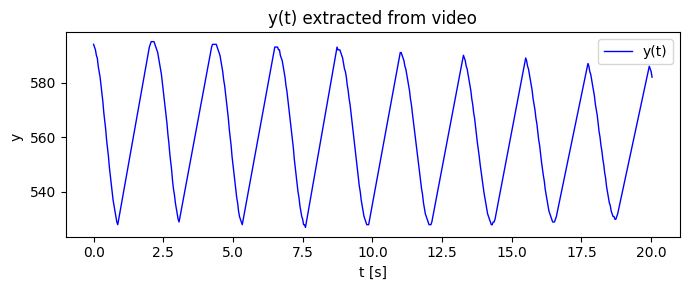

In [29]:


# Graficar la trayectoria de los centroides (si se detectaron)
# Asegurarse de que el DataFrame no esté vacío
if not centroid_df.empty:
    # Extraer las columnas de tiempo y coordenadas Y del DataFrame
    times = centroid_df['Time']
    y_cartesian = centroid_df['Y_Coordinate']
    # Plot the y(t) data
    plt.figure(figsize=(7,3))
    plt.plot(times, y_cartesian, lw=1, color='blue', label="y(t)")
    plt.xlabel("t [s]"); plt.ylabel("y ")
    plt.title("y(t) extracted from video")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid centroids were detected to plot.")


## 2) Método A — Regresión de Derivadas
Suavizamos los datos con Savitzky–Golay, calculamos $\dot y$ y $\ddot y$, y ajustamos el modelo lineal $\ddot y = -a\,\dot y - b\,y$. luego $\omega_0=\sqrt{b}$ y $\zeta=a/(2\,\omega_0)$. Con la masa se obtienen $k$ y $b_{visc}$.


In [30]:
m_true = 0.550


Estimaciones con el Método A:
  omega0 ≈ 0.195404 rad/s
  zeta   ≈ 4.761458
  k      ≈ 0.021000 N/m
  b_visc ≈ 1.023446 N·s/m


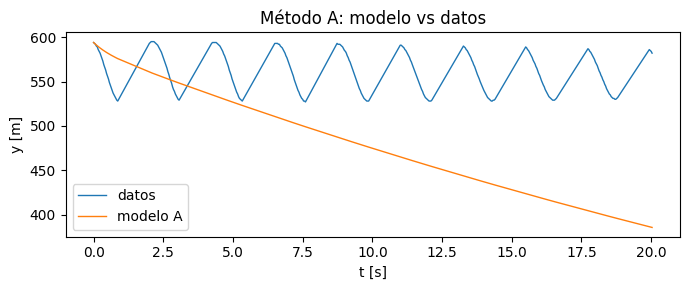

In [31]:
y=y_cartesian
t=times

def auto_window_length(N: int) -> int:
    # Calcula automáticamente una longitud de ventana adecuada (impar y >= 5)
    wl = max(5, (N // 10) | 1)   # ~1/10 de las muestras, impar
    wl = min(wl, N - (1 - (N % 2)))
    if wl < 5:
        wl = 5 if 5 % 2 == 1 else 7
    if wl >= N:
        wl = N-1 if (N-1) % 2 == 1 else N-2
        if wl < 5:
            wl = 5
    return int(wl)

def fit_derivative_regression(t, y, poly=3, window_length=None):
    """
    Ajusta el modelo lineal de regresión de derivadas:
        y'' = -a y' - b y

    Args:
        t: vector de tiempos
        y: señal observada
        poly: orden del polinomio en el filtro Savitzky–Golay
        window_length: longitud de ventana para el suavizado

    Returns:
        Diccionario con a, b, omega0, zeta y las señales suavizadas y derivadas
    """
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    dt = np.median(np.diff(t))
    if window_length is None:
        # Aumentamos ligeramente la longitud de la ventana inicial para un suavizado más fuerte
        window_length = auto_window_length(len(t)) * 2
    window_length = int(window_length)
    # Asegurarse de que la longitud de la ventana sea impar
    if window_length % 2 == 0:
        window_length += 1
    # Asegurarse de que la longitud de la ventana no exceda el número de puntos
    window_length = min(window_length, len(t) - (1 - (len(t) % 2)))
    # Asegurarse de que la longitud de la ventana sea al menos poly + 2
    window_length = max(window_length, poly + 2 if poly + 2 > 5 else 5)


    # Señal suavizada y sus derivadas primera y segunda
    y_s = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1))
    yd = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1), deriv=1, delta=dt)
    ydd = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1), deriv=2, delta=dt)

    # Ajuste lineal: y'' = -a y' - b y
    X = np.column_stack([yd, y_s])
    rhs = -ydd
    theta, *_ = np.linalg.lstsq(X, rhs, rcond=None)
    a, b = theta

    # Parámetros físicos estimados
    omega0 = np.sqrt(abs(b))
    zeta = a / (2.0 * omega0) if omega0 > 0 else 0.0

    return dict(a=a, b=b, omega0=omega0, zeta=zeta, y_s=y_s, yd=yd, ydd=ydd)

# Ajuste con el Método A
A = fit_derivative_regression(times, y_cartesian)
k_A = m_true * (A["omega0"]**2)
b_A = 2 * m_true * A["zeta"] * A["omega0"]

print("Estimaciones con el Método A:")
print(f"  omega0 ≈ {A['omega0']:.6f} rad/s")
print(f"  zeta   ≈ {A['zeta']:.6f}")
print(f"  k      ≈ {k_A:.6f} N/m")
print(f"  b_visc ≈ {b_A:.6f} N·s/m")

# Opcional: construir una señal modelo integrando con k y b estimados
def simulate_ode(t, y0, v0, m, k, b):
    def f(_t, z):
        y, v = z
        return [v, -(b/m)*v - (k/m)*y]
    sol = solve_ivp(f, (t[0], t[-1]), [y0, v0], t_eval=t, method="RK45", rtol=1e-6, atol=1e-9)
    return sol.y[0]

# Condiciones iniciales
y0 = y[0]
v0 = (y[1]-y[0]) / (t[1]-t[0])

# Simulación con los parámetros estimados
yhat_A = simulate_ode(t.values, y0, v0, m_true, k_A, b_A) # Convert t to numpy array

# Gráfico: comparación entre datos y modelo del Método A
plt.figure(figsize=(7,3))
plt.plot(times, y_cartesian, lw=1, label="datos")
plt.plot(t, yhat_A, lw=1, label="modelo A")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Método A: modelo vs datos")
plt.legend()
plt.tight_layout()
plt.show()

Estimaciones con el Método B:
  omega0 ≈ 0.063311 rad/s
  zeta   ≈ 13.373693
  k      ≈ 0.002205 N/m
  b_visc ≈ 0.931378 N·s/m


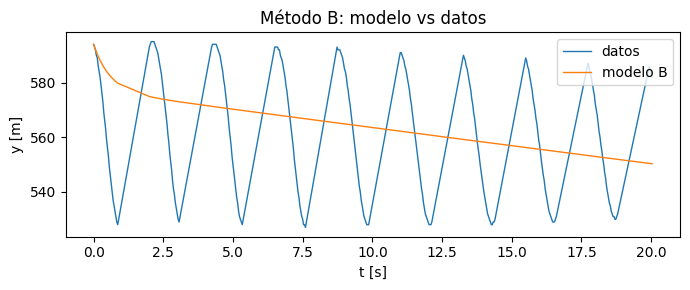

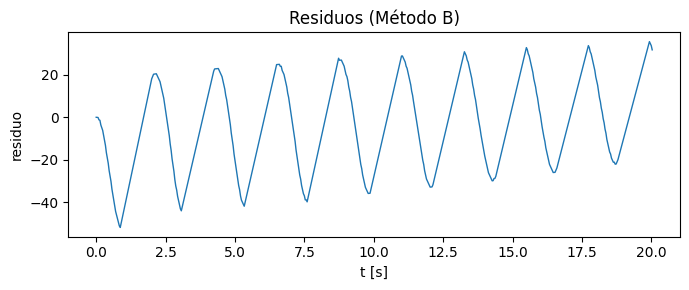

In [34]:
def fit_ode(t, y, m, k0, b0):
    """
    Ajusta los parámetros k y b resolviendo la EDO y minimizando
    la suma de residuos al cuadrado.

    Args:
        t: vector de tiempos
        y: señal observada
        m: masa conocida
        k0, b0: valores iniciales de k y b (ej. estimados del Método A)

    Returns:
        Diccionario con k, b, omega0, zeta, la señal ajustada y el resultado de optimización
    """
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    dt = np.median(np.diff(t))
    y0 = y[0]
    v0 = (y[1]-y[0])/dt if len(t) > 1 else 0.0  # velocidad inicial

    # Simulación de la EDO para un par (k,b)
    def simulate(k, b):
        def f(_t, z):
            yy, vv = z
            return [vv, -(b/m)*vv - (k/m)*yy]
        sol = solve_ivp(f, (t[0], t[-1]), [y0, v0],
                        t_eval=t, method="RK45", rtol=1e-6, atol=1e-9)
        return sol.y[0]

    # Función de residuos (diferencia entre datos y modelo)
    def residual(theta):
        k, b = theta
        yhat = simulate(k, b)
        return yhat - y

    # Optimización no lineal con mínimos cuadrados robustos
    # Ensure initial guess for b is within bounds
    b0_adjusted = max(b0, 1e-9)

    res = least_squares(residual,
                        x0=np.array([k0, b0_adjusted]),
                        # Adjust bounds to be less restrictive if necessary, or based on physical intuition
                        # For now, keeping broad positive bounds
                        bounds=([1e-9, 0.0],[np.inf, np.inf]),
                        method="trf",
                        loss="huber",
                        f_scale=1.0)

    k_fit, b_fit = res.x
    # Add a check for negative k or b resulting from optimization despite bounds
    if k_fit < 0:
        k_fit = 1e-9 # Set to a small positive value
    if b_fit < 0:
         b_fit = 0.0 # Set to zero or a small positive value

    omega0 = np.sqrt(k_fit / m)
    zeta = b_fit / (2*m*omega0) if omega0 > 0 else 0.0
    yhat = simulate(k_fit, b_fit)

    return dict(k=k_fit, b=b_fit, omega0=omega0,
                zeta=zeta, yhat=yhat, result=res)

# Ajuste con el Método B, partiendo de los parámetros del Método A
# Consider using different initial guesses if Method A's results are very far off
B = fit_ode(times.values, y_cartesian, m_true, k_A, b_A)

print("Estimaciones con el Método B:")
print(f"  omega0 ≈ {B['omega0']:.6f} rad/s")
print(f"  zeta   ≈ {B['zeta']:.6f}")
print(f"  k      ≈ {B['k']:.6f} N/m")
print(f"  b_visc ≈ {B['b']:.6f} N·s/m")

# Comparación datos vs modelo B
plt.figure(figsize=(7,3))
plt.plot(times, y_cartesian, lw=1, label="datos")
plt.plot(times, B["yhat"], lw=1, label="modelo B")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Método B: modelo vs datos")
plt.legend()
plt.tight_layout()
plt.show()

# Residuos del ajuste con Método B
plt.figure(figsize=(7,3))
plt.plot(t, y - B["yhat"], lw=1)
plt.xlabel("t [s]"); plt.ylabel("residuo")
plt.title("Residuos (Método B)")
plt.tight_layout()
plt.show()

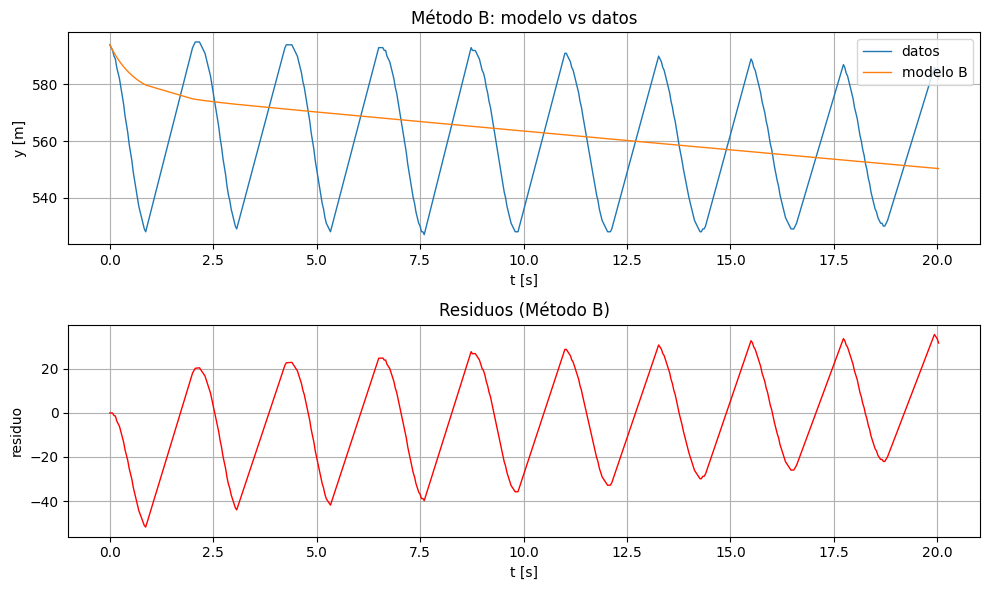

In [35]:
# Gráfico combinado: Modelo B y Residuos
plt.figure(figsize=(10, 6))

# Subplot para el modelo B y los datos
plt.subplot(2, 1, 1) # 2 filas, 1 columna, primer subplot
plt.plot(times, y_cartesian, lw=1, label="datos")
plt.plot(times, B["yhat"], lw=1, label="modelo B")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Método B: modelo vs datos")
plt.legend()
plt.grid(True)

# Subplot para los residuos del Método B
plt.subplot(2, 1, 2) # 2 filas, 1 columna, segundo subplot
plt.plot(t, y - B["yhat"], lw=1, color='red')
plt.xlabel("t [s]"); plt.ylabel("residuo")
plt.title("Residuos (Método B)")
plt.grid(True)

plt.tight_layout() # Ajustar el diseño para evitar solapamiento
plt.show()

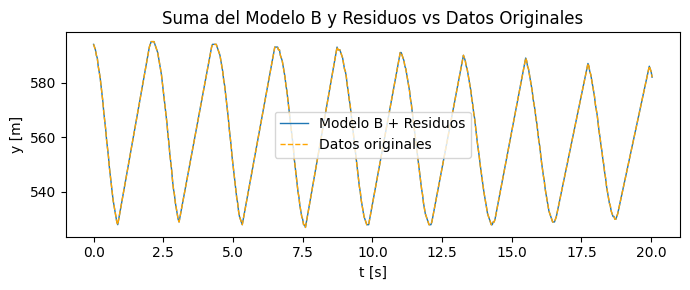

In [36]:
# Calcular la suma del modelo B y los residuos
sum_model_b_residuals = B["yhat"] + (y - B["yhat"])

# Graficar la suma
plt.figure(figsize=(7, 3))
plt.plot(times, sum_model_b_residuals, lw=1, label="Modelo B + Residuos")
plt.plot(times, y_cartesian, lw=1, linestyle='--', color='orange', label="Datos originales") # Opcional: graficar datos originales para comparación
plt.xlabel("t [s]")
plt.ylabel("y [m]")
plt.title("Suma del Modelo B y Residuos vs Datos Originales")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
summary = pd.DataFrame({
    "quantity": ["omega0 [rad/s]", "zeta [-]", "k [N/m]", "b [N·s/m]"],
    "Ideal": [omega0_true, zeta_true, k_true, 2*m_true*zeta_true*omega0_true],
    "Metodo A": [A["omega0"], A["zeta"], m_true*(A["omega0"]**2), 2*m_true*A["zeta"]*A["omega0"]],
    "Metodo B": [B["omega0"], B["zeta"], B["k"], B["b"]],
})
summary

,quantity,Ideal,Metodo A,Metodo B
0,omega0 [rad/s],4.264014,0.195404,0.063311
1,zeta [-],0.030000,4.761458,13.373693
2,k [N/m],10.000000,0.021000,0.002205
3,b [N·s/m],0.140712,1.023446,0.931378
